In [1]:

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from numpy.linalg import inv
import matplotlib.pyplot as plt


2025-06-03 09:01:35.671176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748921495.729989  779857 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748921495.746926  779857 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748921495.875296  779857 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748921495.875313  779857 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748921495.875314  779857 computation_placer.cc:177] computation placer alr

In [2]:
# Define NIFTY 50 stocks
nifty50_stocks = nifty50_stocks = [
    'RELIANCE.NS', 'HDFCBANK.NS', 'INFY.NS', 'TCS.NS', 'ICICIBANK.NS',
    'HINDUNILVR.NS', 'SBIN.NS', 'BAJFINANCE.NS', 'BHARTIARTL.NS', 'ITC.NS',
    'KOTAKBANK.NS', 'LT.NS', 'HCLTECH.NS', 'MARUTI.NS', 'SUNPHARMA.NS',
    'TITAN.NS', 'ULTRACEMCO.NS', 'WIPRO.NS', 'NESTLEIND.NS', 'TECHM.NS',
    'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJFINSV.NS', 'HDFCLIFE.NS', 'TATAMOTORS.NS',
    'POWERGRID.NS', 'COALINDIA.NS', 'ONGC.NS', 'ADANIPORTS.NS', 'GRASIM.NS',
    'NTPC.NS', 'JSWSTEEL.NS', 'HEROMOTOCO.NS', 'CIPLA.NS', 'DRREDDY.NS',
    'DIVISLAB.NS', 'APOLLOHOSP.NS', 'EICHERMOT.NS', 'BRITANNIA.NS', 'INDUSINDBK.NS',
    'SBILIFE.NS', 'HDFCAMC.NS', 'M&M.NS', 'TATACONSUM.NS', 'SHRIRAMFIN.NS',
    'ADANIENT.NS', 'TRENT.NS', 'BEL.NS', 'BPCL.NS', 'IOC.NS'
]
benchmark_name = '^NSEI'



# Fetch price data
price_data = pd.DataFrame()
for stock in nifty50_stocks + [benchmark_name]:
    ticker = yf.Ticker(stock)
    df = ticker.history(start='2020-03-26', end='2025-03-25')['Close']
    price_data[stock] = df

price_data.index = pd.to_datetime(price_data.index)
price_data = price_data.ffill().bfill()
price_data.to_csv('stock_prices.csv')
print("Saved stock_prices.csv")

# Calculate returns
returns = price_data.pct_change().dropna()
returns_stocks = returns[nifty50_stocks]
benchmark = returns[benchmark_name]
returns.to_csv('nifty50_returns.csv')
print("Saved nifty50_returns.csv")

Saved stock_prices.csv
Saved nifty50_returns.csv


In [3]:
# LSTM Forecasting
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(returns_stocks)

lookback = 60
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])
    y.append(scaled_data[i, :])
X, y = np.array(X), np.array(y)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(lookback, len(nifty50_stocks))))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(len(nifty50_stocks)))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)

forecasts = model.predict(X)
forecasted_returns = scaler.inverse_transform(forecasts)
forecast_df = pd.DataFrame(forecasted_returns, index=returns_stocks.index[lookback:], columns=nifty50_stocks)

Q = forecast_df.mean() * 252
Q = Q.clip(lower=0.01)
forecast_df.to_csv('forecasted_daily_returns.csv')
print("Saved forecasted_daily_returns.csv")
annualized_returns_df = pd.DataFrame(Q, columns=['Annualized_Return'])
annualized_returns_df.to_csv('annualized_returns.csv')
print("Saved annualized_returns.csv")

Epoch 1/30


2025-06-03 09:01:46.425668: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/brijesh/Documents/astratinvest/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0894 - val_loss: 0.0074
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0178 - val_loss: 0.0068
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0142 - val_loss: 0.0064
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0129 - val_loss: 0.0060
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0114 - val_loss: 0.0067
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0109 - val_loss: 0.0060
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0102 - val_loss: 0.0061
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0101 - val_loss: 0.0060
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0099 - val_loss: 0.0063
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0091 - val_loss: 0.0060
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0087 - val_loss: 0.0060
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0090 - val_l

In [4]:
# Confidence levels
# Confidence levels
confidence_levels = 1 / returns_stocks.std() * 252
confidence_levels = confidence_levels / confidence_levels.max()
confidence_levels_df = pd.DataFrame(confidence_levels, columns=['Confidence_Level'])
confidence_levels_df.to_csv('confidence_levels.csv')
print("Saved confidence_levels.csv")

Saved confidence_levels.csv


In [5]:
# Black-Litterman Backtesting
rebalance_freq = 'ME'
date_range = pd.date_range(start=returns.index[lookback], end=returns.index[-1], freq=rebalance_freq)
portfolio_returns = pd.Series(index=returns_stocks.index[lookback:], dtype=float)
weights_df = pd.DataFrame(index=returns_stocks.index[lookback:], columns=nifty50_stocks, dtype=float)

print(f"Total rebalancing periods: {len(date_range) - 1}")
for i in range(len(date_range) - 1):
    start_date = date_range[i]
    end_date = date_range[i + 1]
    period_data = returns_stocks.loc[start_date:end_date].iloc[:-1]

    if len(period_data) <= 1:
        print(f"Skipping period {start_date} to {end_date}: insufficient data ({len(period_data)} rows)")
        continue

    cov_matrix = period_data.cov() * 252
    cov_matrix += np.eye(len(nifty50_stocks)) * 1e-6

    market_weights = np.array([1/len(nifty50_stocks)] * len(nifty50_stocks))
    risk_aversion = 2.5
    market_implied_returns = risk_aversion * np.dot(cov_matrix, market_weights)

    P = np.eye(len(nifty50_stocks))
    tau = 0.25
    omega = np.diag(1 / (confidence_levels * 10))

    C = cov_matrix
    tauC = tau * C
    bl_returns = market_implied_returns + np.dot(tauC, P.T) @ inv(np.dot(P, np.dot(tauC, P.T)) + omega) @ (Q.values - np.dot(P, market_implied_returns))

    inverse_cov = inv(C)
    optimal_weights = (1/risk_aversion) * np.dot(inverse_cov, bl_returns)
    optimal_weights = optimal_weights / optimal_weights.sum()

    period_portfolio_returns = (period_data * optimal_weights).sum(axis=1)
    portfolio_returns.loc[period_portfolio_returns.index] = period_portfolio_returns
    weights_df.loc[period_portfolio_returns.index] = optimal_weights
    print(f"Period {start_date} to {end_date}: {len(period_portfolio_returns)} days, Mean return = {period_portfolio_returns.mean():.6f}")

portfolio_returns = portfolio_returns.ffill()
weights_df = weights_df.ffill()
weights_df.to_csv('optimal_weights.csv')
print("Saved optimal_weights.csv")


Total rebalancing periods: 56
Period 2020-06-30 00:00:00+05:30 to 2020-07-31 00:00:00+05:30: 23 days, Mean return = 0.002667
Period 2020-07-31 00:00:00+05:30 to 2020-08-31 00:00:00+05:30: 21 days, Mean return = 0.005688
Period 2020-08-31 00:00:00+05:30 to 2020-09-30 00:00:00+05:30: 22 days, Mean return = -0.001065
Period 2020-09-30 00:00:00+05:30 to 2020-10-31 00:00:00+05:30: 21 days, Mean return = 0.000044
Period 2020-10-31 00:00:00+05:30 to 2020-11-30 00:00:00+05:30: 19 days, Mean return = 0.007922
Period 2020-11-30 00:00:00+05:30 to 2020-12-31 00:00:00+05:30: 21 days, Mean return = 0.003886
Period 2020-12-31 00:00:00+05:30 to 2021-01-31 00:00:00+05:30: 20 days, Mean return = -0.000066
Period 2021-01-31 00:00:00+05:30 to 2021-02-28 00:00:00+05:30: 19 days, Mean return = 0.007385
Period 2021-02-28 00:00:00+05:30 to 2021-03-31 00:00:00+05:30: 20 days, Mean return = -0.000074
Period 2021-03-31 00:00:00+05:30 to 2021-04-30 00:00:00+05:30: 19 days, Mean return = 0.001431
Period 2021-04-30

In [6]:
# Transaction costs
transaction_cost = 0.001
weight_changes = weights_df.diff().abs().sum(axis=1)
portfolio_returns -= transaction_cost * weight_changes

# Stress Testing
full_cov_matrix = returns_stocks.cov() * 252
full_cov_matrix += np.eye(len(nifty50_stocks)) * 1e-6
market_weights = np.array([1/len(nifty50_stocks)] * len(nifty50_stocks))
risk_aversion = 2.5
market_implied_returns = risk_aversion * np.dot(full_cov_matrix, market_weights)
P = np.eye(len(nifty50_stocks))
tau = 0.25
omega = np.diag(1 / (confidence_levels * 10))
C = full_cov_matrix
tauC = tau * C
inverse_cov = inv(C)

stress_scenarios = {'Base': Q.values, 'Bull': Q.values * 1.1, 'Bear': Q.values * 0.9}
stress_weights = {}
for scenario, q_adj in stress_scenarios.items():
    bl_returns_adj = market_implied_returns + np.dot(tauC, P.T) @ inv(np.dot(P, np.dot(tauC, P.T)) + omega) @ (q_adj - np.dot(P, market_implied_returns))
    optimal_weights_adj = (1/risk_aversion) * np.dot(inverse_cov, bl_returns_adj)
    optimal_weights_adj = optimal_weights_adj / optimal_weights_adj.sum()
    stress_weights[scenario] = optimal_weights_adj

stress_weights_df = pd.DataFrame(stress_weights, index=nifty50_stocks)
print("Stress Test Weights:\n", stress_weights_df)

Stress Test Weights:
                    Base      Bull      Bear
RELIANCE.NS    0.009668  0.009630  0.009715
HDFCBANK.NS   -0.040102 -0.040380 -0.039766
INFY.NS        0.004546  0.004459  0.004651
TCS.NS        -0.006497 -0.006638 -0.006327
ICICIBANK.NS   0.015415  0.015428  0.015399
HINDUNILVR.NS  0.020844  0.020805  0.020892
SBIN.NS        0.037602  0.037733  0.037443
BAJFINANCE.NS  0.058401  0.058613  0.058145
BHARTIARTL.NS  0.045293  0.045398  0.045165
ITC.NS         0.046841  0.046941  0.046720
KOTAKBANK.NS  -0.038765 -0.039047 -0.038424
LT.NS          0.001094  0.001037  0.001164
HCLTECH.NS     0.036485  0.036558  0.036397
MARUTI.NS      0.008657  0.008618  0.008703
SUNPHARMA.NS   0.037387  0.037454  0.037305
TITAN.NS       0.037799  0.037900  0.037677
ULTRACEMCO.NS  0.006566  0.006531  0.006608
WIPRO.NS       0.013995  0.013964  0.014032
NESTLEIND.NS  -0.003562 -0.003719 -0.003372
TECHM.NS       0.016112  0.016088  0.016140
ASIANPAINT.NS  0.069443  0.069662  0.069178
AXISBANK.N

In [7]:
# Backtesting Metrics and Plots
cumulative_returns = (1 + portfolio_returns).cumprod()
benchmark_returns = benchmark[portfolio_returns.index]
benchmark_cumulative = (1 + benchmark_returns).cumprod()

portfolio_annual_return = portfolio_returns.mean() * 252
benchmark_annual_return = benchmark_returns.mean() * 252
portfolio_volatility = portfolio_returns.std() * np.sqrt(252)
benchmark_volatility = benchmark_returns.std() * np.sqrt(252)
risk_free_rate = 0.06
sharpe_ratio = (portfolio_annual_return - risk_free_rate) / portfolio_volatility
benchmark_sharpe = (benchmark_annual_return - risk_free_rate) / benchmark_volatility
max_drawdown = ((cumulative_returns.cummax() - cumulative_returns) / cumulative_returns.cummax()).max()
benchmark_max_drawdown = ((benchmark_cumulative.cummax() - benchmark_cumulative) / benchmark_cumulative.cummax()).max()

# Print metrics
print("\nPortfolio Metrics:")
print(f"Annualized Return: {portfolio_annual_return:.4f}")
print(f"Volatility: {portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.4f}")
print("\nBenchmark (NIFTY 50) Metrics:")
print(f"Annualized Return: {benchmark_annual_return:.4f}")
print(f"Volatility: {benchmark_volatility:.4f}")
print(f"Sharpe Ratio: {benchmark_sharpe:.4f}")
print(f"Maximum Drawdown: {benchmark_max_drawdown:.4f}")


Portfolio Metrics:
Annualized Return: 0.3012
Volatility: 0.1334
Sharpe Ratio: 1.8087
Maximum Drawdown: 0.1893

Benchmark (NIFTY 50) Metrics:
Annualized Return: 0.1871
Volatility: 0.1453
Sharpe Ratio: 0.8750
Maximum Drawdown: 0.1723


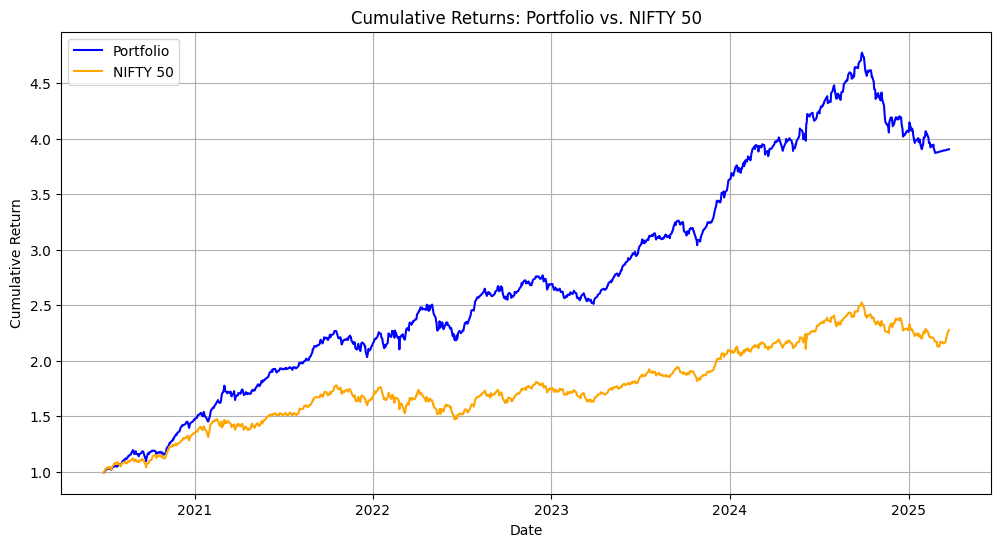

In [8]:
# Plot 1: Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns, label='Portfolio', color='blue')
plt.plot(benchmark_cumulative.index, benchmark_cumulative, label='NIFTY 50', color='orange')
plt.title('Cumulative Returns: Portfolio vs. NIFTY 50')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

plt.grid(True)
plt.savefig('cumulative_returns_plot.png')
plt.show()

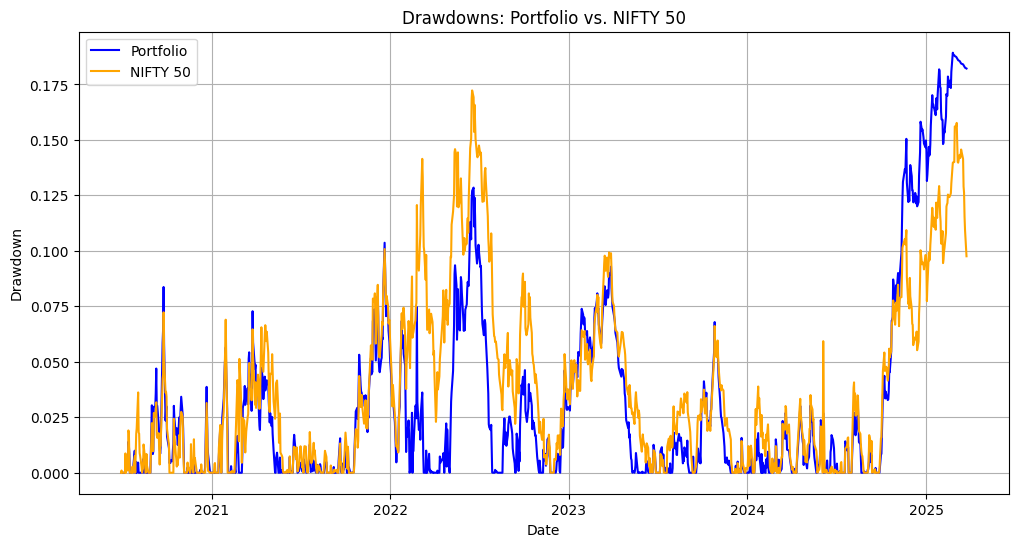

In [9]:
# Plot 2: Drawdowns
portfolio_drawdowns = (cumulative_returns.cummax() - cumulative_returns) / cumulative_returns.cummax()
benchmark_drawdowns = (benchmark_cumulative.cummax() - benchmark_cumulative) / benchmark_cumulative.cummax()
plt.figure(figsize=(12, 6))
plt.plot(portfolio_drawdowns.index, portfolio_drawdowns, label='Portfolio', color='blue')
plt.plot(benchmark_drawdowns.index, benchmark_drawdowns, label='NIFTY 50', color='orange')
plt.title('Drawdowns: Portfolio vs. NIFTY 50')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.savefig('drawdowns_plot.png')  # Save plot for report
plt.show()